In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib import rcParams
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#import pyspark as ps
#spark = (ps.sql.SparkSession.builder
#        .appName("sandbox")
#        .getOrCreate()
#        )

from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
print(spark.version)
sc = spark.sparkContext

3.1.1


# 1. Load data and check data quality

## 1.1 Patient data

In [3]:
# The csv files are stored in a folder named data in the current working directory
DATA_DIR = os.path.join('.',"data")

In [4]:
data_pt = pd.read_csv(os.path.join(DATA_DIR, 'patient.csv'), sep='\t')
data_pt.rename(columns={'patientid': 'pt_id'}, inplace=True)
data_pt.head()
data_pt.shape
data_pt.dtypes

,pt_id,sex
0,13151,Female
1,43463,Female
2,42834,Male
3,37531,Female
4,31613,Female


(945, 2)

pt_id     int64
sex      object
dtype: object

> -----------------------------------------------------------pyspark -----------------------------------------------------------

In [5]:
spdf_pt = spark.read.load(os.path.join(DATA_DIR, 'patient.csv'), format='csv', sep='\t', inferSchema="true", header='true')
spdf_pt = spdf_pt.withColumnRenamed('patientid', 'pt_id')
spdf_pt.show(5)
print((spdf_pt.count(), len(spdf_pt.columns)))
spdf_pt.printSchema()

+-----+------+
|pt_id|   sex|
+-----+------+
|13151|Female|
|43463|Female|
|42834|  Male|
|37531|Female|
|31613|Female|
+-----+------+
only showing top 5 rows

(945, 2)
root
 |-- pt_id: integer (nullable = true)
 |-- sex: string (nullable = true)



> ----------------------------Pandas profiling----------------------------

#### Check and remove the duplicate values

#### Note: there are patients with multiple sex values. Remove those duplicates

In [6]:
data_pt.drop_duplicates(subset=['pt_id'], inplace=True)
data_pt.shape

(932, 2)

In [7]:
data_pt.sex.value_counts()

Female          515
Male            384
male             10
female            9
Not Reported      9
f                 3
M                 1
m                 1
Name: sex, dtype: int64

> -----------------------------------------------------------pyspark -----------------------------------------------------------

In [8]:
spdf_pt = spdf_pt.dropDuplicates(['pt_id'])
print((spdf_pt.count(), len(spdf_pt.columns)))
#from pyspark.sql import functions as F
#df1 = spdf_pt.groupby("sex").agg(F.count("pt_id").alias("gender"))
spdf_pt.groupby("sex").count().orderBy('count', ascending=False).show()

(932, 2)
+------------+-----+
|         sex|count|
+------------+-----+
|      Female|  515|
|        Male|  384|
|        male|   10|
|Not Reported|    9|
|      female|    9|
|           f|    3|
|           m|    1|
|           M|    1|
+------------+-----+



#### We standardize the values of sex, F for Female, M for Male, N for Not Reported. The gender distribution is imbalanced

In [9]:
data_pt['sex'] = data_pt['sex'].astype(str).str.upper().str[0]
data_pt.sex.value_counts()

F    527
M    396
N      9
Name: sex, dtype: int64

> -----------------------------------------------------------pyspark -----------------------------------------------------------

In [10]:
from pyspark.sql.functions import upper
spdf_pt = spdf_pt.withColumn("unified_gender", upper(spdf_pt.sex.substr(1, 1)))
spdf_pt.groupby('sex').count().orderBy('count', ascending=False).show()
spdf_pt.groupby('unified_gender').count().orderBy('count', ascending=False).show()
#spdf_pt.show()

+------------+-----+
|         sex|count|
+------------+-----+
|      Female|  515|
|        Male|  384|
|        male|   10|
|      female|    9|
|Not Reported|    9|
|           f|    3|
|           m|    1|
|           M|    1|
+------------+-----+

+--------------+-----+
|unified_gender|count|
+--------------+-----+
|             F|  527|
|             M|  396|
|             N|    9|
+--------------+-----+



In [11]:
#Check missing values in specified columns.  
columns_to_check =['pt_id', 'sex']
row_with_missing = [row_idx for row_idx, row in data_pt[columns_to_check].isnull().iterrows() if True in row.values]
print("\nMissing Value Summary\n{}".format("-"*35))
print(data_pt.isnull().sum(axis = 0))
if len(row_with_missing) > 0:
    print("There were {} rows with missing diagnosis in data_pct dataset".format(len(row_with_missing)))
else:
    print("There were no rows with missing data")


Missing Value Summary
-----------------------------------
pt_id    0
sex      0
dtype: int64
There were no rows with missing data


> -----------------------------------------------------------pyspark -----------------------------------------------------------

In [12]:
from pyspark.sql.functions import isnan, when, count, col
spdf_pt.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in spdf_pt.columns]).show()
spdf_pt.select([count(when(col(c)=='null', c)).alias(c) for c in spdf_pt.columns]).show()

+-----+---+--------------+
|pt_id|sex|unified_gender|
+-----+---+--------------+
|    0|  0|             0|
+-----+---+--------------+

+-----+---+--------------+
|pt_id|sex|unified_gender|
+-----+---+--------------+
|    0|  0|             0|
+-----+---+--------------+



## 1.2. Check diagnosis data

In [13]:
data_dx = pd.read_csv(os.path.join(DATA_DIR, 'diagnosis.csv'), sep='\t')
data_dx.head()
data_dx.shape
data_dx.dtypes

,pt_id,dos,dx_code
0,13151,2018-04-10,H35.3231
1,13151,2018-05-22,H35.3231
2,13151,2018-07-17,H35.3220
3,13151,2018-09-25,H35.3220
4,13151,2018-12-18,H35.3220


(4672, 3)

pt_id       int64
dos        object
dx_code    object
dtype: object

In [14]:
# change the dos type to datatime and creat a new column of year 
data_dx["dos"] = pd.to_datetime(data_dx['dos'])
data_dx['year']=data_dx['dos'].dt.year

In [15]:
data_dx.drop_duplicates(inplace=True)
data_dx.shape

(4484, 4)

 > -------------------------------Pandas profiling tools-------------------------------

#### There are 152 diagnosis codes. The top 3 are H35.32, 362.52, E11.9

In [16]:
data_dx.dx_code.value_counts()

H35.32       402
362.52       395
E11.9        244
H35.033      197
H35.3220     155
            ... 
H35.3112       1
36252          1
414173003      1
60189009       1
312956001      1
Name: dx_code, Length: 152, dtype: int64

In [17]:
# change the dos type to datatime and creat a new column of year 
data_dx["dos"] = pd.to_datetime(data_dx['dos'])
data_dx['year']=data_dx['dos'].dt.year

In [18]:
#Check missing values in specified columns. Note the missing value in Treatment Plan is not counted. 
columns_to_check =['pt_id', 'dos', 'dx_code']
row_with_missing = [row_idx for row_idx, row in data_dx[columns_to_check].isnull().iterrows() if True in row.values]
print("\nMissing Value Summary\n{}".format("-"*35))
print(data_dx.isnull().sum(axis = 0))
if len(row_with_missing) > 0:
    print("There were {} rows with missing diagnosis in data_pct dataset".format(len(row_with_missing)))
else:
    print("There were no rows with missing data")


Missing Value Summary
-----------------------------------
pt_id      0
dos        0
dx_code    0
year       0
dtype: int64
There were no rows with missing data


> -----------------------------------------------------------pyspark -----------------------------------------------------------

In [19]:
spdf_dx = spark.read.load(os.path.join(DATA_DIR, 'diagnosis.csv'), format='csv', sep='\t', inferSchema="true", header='true')
#spdf_dx = spdf_pt.withColumnRenamed('patientid', 'pt_id')
spdf_dx.show(5)
spdf_dx.printSchema()
print((spdf_dx.count(), len(spdf_dx.columns)))

+-----+----------+--------+
|pt_id|       dos| dx_code|
+-----+----------+--------+
|13151|2018-04-10|H35.3231|
|13151|2018-05-22|H35.3231|
|13151|2018-07-17|H35.3220|
|13151|2018-09-25|H35.3220|
|13151|2018-12-18|H35.3220|
+-----+----------+--------+
only showing top 5 rows

root
 |-- pt_id: integer (nullable = true)
 |-- dos: string (nullable = true)
 |-- dx_code: string (nullable = true)

(4672, 3)


In [20]:
spdf_dx = spdf_dx.dropDuplicates()
print((spdf_dx.count(), len(spdf_dx.columns)))

(4484, 3)


In [21]:
from pyspark.sql.functions import year
from pyspark.sql.types import DateType
spdf_dx = spdf_dx.withColumn("year", year(spdf_dx.dos.cast(DateType())))
spdf_dx.show(5)

+-----+----------+--------+----+
|pt_id|       dos| dx_code|year|
+-----+----------+--------+----+
|37531|2019-07-23| H35.321|2019|
|49241|2019-04-18|H35.3220|2019|
|30912|2016-11-01| H35.051|2016|
|16194|2016-12-08| H35.031|2016|
|14289|2017-12-04|  H35.32|2017|
+-----+----------+--------+----+
only showing top 5 rows



In [22]:
from pyspark.sql.functions import isnan, when, count, col, isnull
spdf_dx.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in spdf_dx.columns]).show()
spdf_dx.select([count(when(col(c)=='null', c)).alias(c) for c in spdf_dx.columns]).show()

+-----+---+-------+----+
|pt_id|dos|dx_code|year|
+-----+---+-------+----+
|    0|  0|      0|   0|
+-----+---+-------+----+

+-----+---+-------+----+
|pt_id|dos|dx_code|year|
+-----+---+-------+----+
|    0|  0|      0|   0|
+-----+---+-------+----+



In [23]:
spdf_dx.groupBy('dx_code').count().orderBy('count', ascending=False).show()
#spdf_dx.select('dx_code').distinct().collect()

+--------+-----+
| dx_code|count|
+--------+-----+
|  H35.32|  402|
|  362.52|  395|
|   E11.9|  244|
| H35.033|  197|
|H35.3220|  155|
|  H25.13|  152|
|  H35.81|  140|
|H35.3290|  135|
| H35.321|  127|
| E11.331|  115|
| H43.813|  106|
|  362.51|   97|
|  362.02|   85|
|  362.07|   81|
|  379.23|   76|
|  362.35|   65|
|  E78.00|   64|
|  H18.59|   59|
|  361.81|   58|
| H04.123|   56|
+--------+-----+
only showing top 20 rows



## 1.3. Check the procedure dataset

In [24]:
data_pct = pd.read_csv(os.path.join(DATA_DIR, 'procedure.csv'), sep='\t')
data_pct.rename(columns={'patient_id': 'pt_id'}, inplace=True)
data_pct.head()
data_pct.dtypes
data_pct.shape

,pt_id,dos,procedure_code,mod
0,10026,12/14/19,2027F,NaN
1,10026,11/13/19,92014,25
2,10026,11/6/19,G8427,NaN
3,10026,10/2/19,92134,NaN
4,10026,9/23/19,92014,25


pt_id              int64
dos               object
procedure_code    object
mod               object
dtype: object

(5222, 4)

In [25]:
data_pct.drop_duplicates(inplace=True)
data_pct.shape

(5149, 4)

In [26]:
# change the dos type to datatime and creat a new column of year 
data_pct["dos"] = pd.to_datetime(data_pct['dos'])
data_pct['year']=data_pct['dos'].dt.year
data_pct.head()

,pt_id,dos,procedure_code,mod,year
0,10026,2019-12-14,2027F,NaN,2019
1,10026,2019-11-13,92014,25,2019
2,10026,2019-11-06,G8427,NaN,2019
3,10026,2019-10-02,92134,NaN,2019
4,10026,2019-09-23,92014,25,2019


#### There are 86 procedure codes.

In [27]:
data_pct.procedure_code.value_counts()
data_pct['procedure_code'].unique()
#data_pct.dos.value_counts()
#data_pct.year.value_counts()

92134         757
92014         581
67028         474
92012         442
99213         250
             ... 
J2778,05MG      1
J0178OU         1
J2778-5         1
J3490           1
LUC5MG          1
Name: procedure_code, Length: 86, dtype: int64

array(['2027F', '92014', 'G8427', '92134', '2026F', '1036F', '92012',
       '92226', 'EYLEAX1', '99213', '92015', '99212', '3072F', '2019F',
       '4177F', '92083', '67210', '92250', 'C9257', '92235', 'G8397',
       '92135', '99214', '76512', '67228', '92133', '2022F', '5010F',
       '2024F', '4040F', '3284F', '92225', '67028', 'J2778PF', 'J3590',
       'J9035', '92273', 'G8482', '67040', '92020', 'G8420', '99499',
       '92136', 'G8950', '67028MCR', 'J0178OU', 'J0178', 'LACS', '92002',
       '99024', 'G8753', 'LUC5SYRX1', 'G8756', 'G8754', 'G9974', 'J2778',
       'J7312', '92242', '67041', '92081', 'G9744', '66984', 'J7999',
       '3285F', '2021F', 'J2778-5', 'J2778,05MG', 'J2778-5P', 'G8752',
       'AVASTIN', 'G9903', 'RS000', '66821', 'G8918', 'G8907', 'J3490',
       '1', 'J9035,J3490,Q9977', 'D0000', '92283', 'J2778P', 'LUC5MG',
       'G8428', 'J2778DME', '92240', 'J2778POU'], dtype=object)

In [28]:
#Check missing values in specified columns. Note the missing value in Treatment Plan is not counted. 
columns_to_check =['pt_id', 'dos', 'procedure_code', 'mod']
row_with_missing = [row_idx for row_idx,row in data_pct[columns_to_check].isnull().iterrows() if True in row.values]
print("\nMissing Value Summary\n{}".format("-"*35))
print(data_pct.isnull().sum(axis = 0))
if len(row_with_missing) > 0:
    print("There were {} rows with missing values in data_pct dataset".format(len(row_with_missing)))
else:
    print("There were no rows with missing data")


Missing Value Summary
-----------------------------------
pt_id                0
dos                  0
procedure_code       0
mod               3709
year                 0
dtype: int64
There were 3709 rows with missing values in data_pct dataset


#### Fill missing values with NA

In [29]:
data_pct = data_pct.fillna("NA").reset_index(drop = True)

In [30]:
data_pct['mod'].value_counts()

NA          3709
25           501
RT           433
LT           291
24            68
50            49
79            35
57            20
8P            20
59            10
TC             8
18944008       5
Name: mod, dtype: int64

> -------------------------------------------------------------pyspark-------------------------------------------------------------

In [31]:
spdf_pct = spark.read.load(os.path.join(DATA_DIR, 'procedure.csv'), format='csv', sep='\t', inferSchema="true", header='true')
spdf_pct = spdf_pct.withColumnRenamed('patient_id', 'pt_id')
spdf_pct.show(5)
spdf_pct.printSchema()
print(spdf_pct.count(), len(spdf_pct.columns))
#spdf_pct.toPandas().shape

+-----+--------+--------------+----+
|pt_id|     dos|procedure_code| mod|
+-----+--------+--------------+----+
|10026|12/14/19|         2027F|null|
|10026|11/13/19|         92014|  25|
|10026| 11/6/19|         G8427|null|
|10026| 10/2/19|         92134|null|
|10026| 9/23/19|         92014|  25|
+-----+--------+--------------+----+
only showing top 5 rows

root
 |-- pt_id: integer (nullable = true)
 |-- dos: string (nullable = true)
 |-- procedure_code: string (nullable = true)
 |-- mod: string (nullable = true)

5222 4


In [32]:
spdf_pct = spdf_pct.dropDuplicates()
#spdf_dx.show(5)
print((spdf_pct.count(), len(spdf_pct.columns)))

(5149, 4)


In [33]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf, year

udf1 = udf(lambda x: '20'+x[-2:], StringType())
spdf_pct = spdf_pct.withColumn('year',year(udf1('dos')))
spdf_pct.show()

+-----+--------+--------------+----+----+
|pt_id|     dos|procedure_code| mod|year|
+-----+--------+--------------+----+----+
|10482|12/28/18|         67028|  LT|2018|
|14795| 1/17/19|         67028|null|2019|
|15561|12/21/15|         3285F|null|2015|
|16910|12/14/14|         92134|null|2014|
|18796| 12/8/16|         4177F|null|2016|
|18796| 7/13/16|         92134|null|2016|
|19922|12/20/16|         92014|null|2016|
|21853| 3/29/14|         1036F|null|2014|
|25601| 9/15/16|         92134|null|2016|
|25601| 9/27/17|         92134|  50|2017|
|26375| 2/24/15|         92014|null|2015|
|26660| 1/19/17|         2019F|null|2017|
|26668| 8/20/13|         99214|null|2013|
|27032|  9/2/15|         92014|null|2015|
|27468| 7/11/13|         92134|null|2013|
|31132|12/30/14|         G8427|null|2014|
|34041|12/19/13|         92012|null|2013|
|38768|10/16/18|         J9035|null|2018|
|39498| 11/7/19|         92083|null|2019|
|41892| 4/24/17|         92133|null|2017|
+-----+--------+--------------+---

In [34]:
from pyspark.sql.functions import isnan, when, count, col, isnull
spdf_pct.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in spdf_pct.columns]).show()
spdf_pct.select([count(when(col(c)=='null', c)).alias(c) for c in spdf_pct.columns]).show()

+-----+---+--------------+---+----+
|pt_id|dos|procedure_code|mod|year|
+-----+---+--------------+---+----+
|    0|  0|             0|  0|   0|
+-----+---+--------------+---+----+

+-----+---+--------------+----+----+
|pt_id|dos|procedure_code| mod|year|
+-----+---+--------------+----+----+
|    0|  0|             0|3709|   0|
+-----+---+--------------+----+----+



In [35]:
#spdf_dx.dx_code.unique()
spdf_pct.groupBy('procedure_code').count().orderBy('count', ascending=False).show()
spdf_pct.groupBy('mod').count().orderBy('count', ascending=False).show()
#spdf_dx.select('dx_code').distinct().collect()

+--------------+-----+
|procedure_code|count|
+--------------+-----+
|         92134|  757|
|         92014|  581|
|         67028|  474|
|         92012|  442|
|         99213|  250|
|         92226|  219|
|         G8427|  180|
|         99214|  160|
|         J9035|  144|
|         J0178|  132|
|         1036F|  127|
|         4177F|  118|
|         2019F|  118|
|         J2778|   83|
|         2022F|   78|
|         67210|   75|
|         92250|   68|
|         99499|   54|
|         G8397|   50|
|         5010F|   50|
+--------------+-----+
only showing top 20 rows

+--------+-----+
|     mod|count|
+--------+-----+
|    null| 3709|
|      25|  501|
|      RT|  433|
|      LT|  291|
|      24|   68|
|      50|   49|
|      79|   35|
|      8P|   20|
|      57|   20|
|      59|   10|
|      TC|    8|
|18944008|    5|
+--------+-----+



#### There are 11 modifier codes.

# 2. Answers to questions

### Q1. What are the types of data quality issues or checks should you consider?

Data quality checks include: 
* Duplicate data
* Data with missing values 
* Data accuracy such as data range, closeness of data values with real-world values. 
* Data type and format
* Consistency of data such as medical code over time or across sites
* Data distribution and outliers

### Q2. How many patients have Wet Age-Related Macular Degeneration (wAMD) in the given dataset?

In [36]:
data_dx.dx_code.value_counts()

H35.32       402
362.52       395
E11.9        244
H35.033      197
H35.3220     155
            ... 
H35.3112       1
36252          1
414173003      1
60189009       1
312956001      1
Name: dx_code, Length: 152, dtype: int64

#### The diagnosis code for wAMD is **362.52** in ICD-9-CM, and **H35.32XX** in ICD-10-CM, respectively

In [37]:
# h is the group of patients diagnozed with wAMD which is coded as H35.32XX and 362.52 in ICD-9-CM
h=data_dx[data_dx['dx_code'].str.contains('H35.32|362.52', case=False)]
#h
print('The numbe of records with Wet Age-Related Macular Degeneration (wAMD) diagnosis is: {}'.format(len(h)))
print('The numbe of patients having Wet Age-Related Macular Degeneration (wAMD) is: {}'.format(len(set(h['pt_id']))))

The numbe of records with Wet Age-Related Macular Degeneration (wAMD) diagnosis is: 1251
The numbe of patients having Wet Age-Related Macular Degeneration (wAMD) is: 418


> ---------------------------------------------pyspark---------------------------------------------

In [38]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
spdf_dx.registerTempTable('dx_table')
sDF = sqlContext.sql('select count(DISTINCT pt_id)\
                    from dx_table \
                    where (upper(dx_code) LIKE upper("%H35.32%") OR dx_code LIKE "%362.52%") \
                     ')
sDF.show()

+---------------------+
|count(DISTINCT pt_id)|
+---------------------+
|                  418|
+---------------------+



### Q3. How many patients have wAMD in 2019?

In [39]:
print('The numbe of patients having wAMD in 2019 is: {}'.format(len(set(h[h['year']==2019]['pt_id']))))

The numbe of patients having wAMD in 2019 is: 66


> ---------------------------------------------pyspark---------------------------------------------

In [40]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
spdf_dx.registerTempTable('dx_table')
sDF = sqlContext.sql('select count(DISTINCT pt_id) \
                    from dx_table \
                    where (upper(dx_code) LIKE upper("%H35.32%") OR dx_code LIKE "%362.52%") \
                    AND year==2019 \
                     ')
sDF.show()

+---------------------+
|count(DISTINCT pt_id)|
+---------------------+
|                   66|
+---------------------+



### Q4. How many patients have wAMD between 2014-2017, stratified by sex?

#### Building a subgroup of patients diagnosed wAMD between 2014 and 2017 by joining patient and diagnosis tables on patient id

In [41]:
# pt_h_14to17 is the subgroup of patients diagnozed wAMD between 2014 and 2017 by joining patient data and diagnosis data on patient id
pt_h = pd.merge(data_pt, h, on='pt_id', how='right')
pt_h_14to17=pt_h[(pt_h['year']>=2014) & (pt_h['year']<=2017)]
pt_h_14to17

,pt_id,sex,dos,dx_code,year
23,42834,M,2017-02-08,H35.3220,2017
24,42834,M,2017-04-12,H35.3210,2017
25,42834,M,2017-06-14,H35.3220,2017
26,42834,M,2017-08-23,H35.3220,2017
27,42834,M,2017-11-15,H35.3220,2017
...,...,...,...,...,...
1243,18683,M,2015-06-22,362.52,2015
1244,18683,M,2015-07-02,362.52,2015
1245,17449,F,2015-07-12,362.52,2015
1246,17449,F,2015-07-22,362.52,2015


In [42]:
print('The numbe of patients having Wet Age-Related Macular Degeneration (wAMD) between 2014 and 2017, stratified by sex')
temp=pt_h_14to17.groupby(['sex'],as_index=False).agg(order=('pt_id', 'nunique'))
temp

The numbe of patients having Wet Age-Related Macular Degeneration (wAMD) between 2014 and 2017, stratified by sex


,sex,order
0,F,173
1,M,129
2,N,1


> -------------------------------------------pyspark-------------------------------------------

In [43]:
spdf_pt.registerTempTable('pt_table')
sdf = sqlContext.sql('select *\
                    from dx_table d JOIN pt_table p ON d.pt_id=p.pt_id \
                    where (upper(dx_code) LIKE upper("%H35.32%") OR dx_code LIKE "%362.52%") \
                    AND year BETWEEN 2014 AND 2017')
sdf.show(5)
#spdf_pct.groupBy('mod').count().orderBy('count', ascending=False).show()

+-----+----------+-------+----+-----+------+--------------+
|pt_id|       dos|dx_code|year|pt_id|   sex|unified_gender|
+-----+----------+-------+----+-----+------+--------------+
|14289|2017-12-04| H35.32|2017|14289|  Male|             M|
|33971|2017-01-04| H35.32|2017|33971|  Male|             M|
|14518|2017-07-06| H35.32|2017|14518|Female|             F|
|39000|2016-02-04| H35.32|2016|39000|Female|             F|
|28812|2014-08-16| 362.52|2014|28812|  Male|             M|
+-----+----------+-------+----+-----+------+--------------+
only showing top 5 rows



In [44]:
from pyspark.sql.functions import countDistinct
sdf.groupby('unified_gender').agg(countDistinct('d.pt_id')).show()

+--------------+--------------+
|unified_gender|count(d.pt_id)|
+--------------+--------------+
|             F|           173|
|             M|           129|
|             N|             1|
+--------------+--------------+



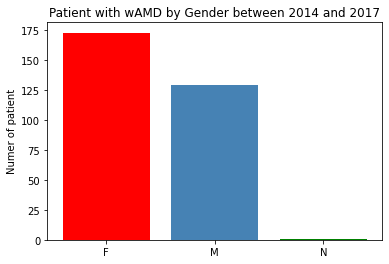

In [45]:
plt.bar(temp['sex'], temp['order'], color=('red','steelblue','green'))
plt.title('Patient with wAMD by Gender between 2014 and 2017')
plt.ylabel('Numer of patient');
plt.show();

### Q5. How would you determine if sex is associated with an increased risk of wAMD?

The total number of wAMD patients and the non-WAMD patient are calculated from patient and diagnosis data, stratified by sex. We perform a Chi-Square test to check whether there is any relationship between **Gender** and **wAMD**. 

1. Define the hypothesis:
* Null Hypothesis: two variables are independent.
* Alternate Hypothesis: two variables are not independent.

2. Built the contingency table 

In [46]:
pid=set(h['pt_id'])
pos=data_pt.set_index('pt_id').loc[pid, :].reset_index().groupby('sex').agg(cnt=('pt_id', 'nunique'))
neg=data_pt.groupby('sex').agg(cnt=('pt_id', 'nunique'))-pos
tab=pd.concat([pos.rename(columns={'cnt':'wAMD'}), neg.rename(columns={'cnt': 'non-wAMD'})], axis=1).iloc[:2,:]
tab

,wAMD,non-wAMD
sex,,
F,235,292
M,178,218


3. Calculate the Chi-square statistics

In [47]:
from scipy import stats
chi2, pval, dof, expected = stats.chi2_contingency(observed=tab)
print('The p-value of Chi-square test is {}'.format(pval))

The p-value of Chi-square test is 0.9671158089335514


4. Results:

With the currently available data, the association between sex and the risk of wAMD can be roughly calculated with Chi-square as shown above. Based on the p-value from the test, we'd accept the Null Hypothesis that there is no association between sex and the risk of wAMD.

5. Discussions:

However, such conclusion could be misleading for two reasons: 
* It didn’t take other confounding factors into account.
* The sample may poorly represent the general population. 

To further estimate the association, random sampling in the general population and complete demographic data of the sample such as age, race, and medical history et al are necessary. Using supervised learning algorithms such as logistic regression, the association of individual parameters including sex with the risk of wAMD can be better evaluated.

### Q6. How many women diagnosed with wAMD between 2014-2017 also had an intravitreal injection during that time?

#### Joining the subgroup of patients diagnosed with wAMD during 2014-2017 with procedure table on patient id and year

 > <span style="color:red">-----------------------------------WRONG Answer in python---------------------------------------------</span>

 > -----------------------------------Right Answer in python---------------------------------------------

In [48]:
#pt_h_14to17 is the group having Wet Age-Related Macular Degeneration (wAMD) between 2014 and 2017,
pt_h_pct = pd.merge(data_pct, pt_h_14to17, on=['pt_id'], how='inner')
pt_h_pct_F=pt_h_pct[(pt_h_pct['sex']=='F') & (pt_h_pct['year_x']>=2014) & (pt_h_pct['year_x']<=2017)]
pt_h_pct_F.head(20)

,pt_id,dos_x,procedure_code,mod,year_x,sex,dos_y,dx_code,year_y
1205,10534,2014-11-20,2022F,NA,2014,F,2014-11-20,362.52,2014
1232,10698,2014-05-18,67228,NA,2014,F,2014-10-07,362.52,2014
1233,10698,2014-10-07,G8427,NA,2014,F,2014-10-07,362.52,2014
1234,10698,2017-05-08,4177F,NA,2017,F,2014-10-07,362.52,2014
1236,11250,2014-11-20,2024F,NA,2014,F,2014-11-20,362.52,2014
1237,11335,2015-06-02,1036F,NA,2015,F,2015-06-02,362.52,2015
1239,11335,2017-07-12,99213,NA,2017,F,2015-06-02,362.52,2015
1248,11468,2017-10-10,92012,24,2017,F,2015-11-18,H35.32,2015
1249,11468,2017-10-10,92012,24,2017,F,2016-06-07,H35.32,2016
1250,11468,2017-07-11,92134,NA,2017,F,2015-11-18,H35.32,2015


#### The procedure code of intravitreal injection is **67028**

In [49]:
#set(pt_h_pct_F[pt_h_pct_F['procedure_code'].isin(['67028'])]['pt_id'])
print('The number of women diagnosed with wAMD between 2014-2017 also had an intravitreal injection during the time is: {}'.\
      format(len(set(pt_h_pct_F[pt_h_pct_F['procedure_code'].isin(['67028'])]['pt_id']))))

The number of women diagnosed with wAMD between 2014-2017 also had an intravitreal injection during the time is: 13


> ----------------------------------------------pyspark----------------------------------------------

In [50]:
spdf_pct.registerTempTable('pct_table')

sdf_f = sqlContext.sql('select *\
                    from dx_table d JOIN pt_table p ON d.pt_id=p.pt_id JOIN pct_table pc ON p.pt_id=pc.pt_id \
                    where (upper(dx_code) LIKE upper("%H35.32%") OR dx_code LIKE "%362.52%") \
                    AND d.year BETWEEN 2014 AND 2017 \
                    AND pc.year BETWEEN 2014 AND 2017 AND pc.procedure_code LIKE "%67028%" \
                    AND unified_gender LIKE "F" \
                    ')
sdf_f.show()
sdf_f.groupBy('unified_gender').agg(countDistinct('d.pt_id')).show()

+-----+----------+--------+----+-----+------+--------------+-----+--------+--------------+----+----+
|pt_id|       dos| dx_code|year|pt_id|   sex|unified_gender|pt_id|     dos|procedure_code| mod|year|
+-----+----------+--------+----+-----+------+--------------+-----+--------+--------------+----+----+
|49241|2014-10-27|  362.52|2014|49241|Female|             F|49241| 2/20/17|         67028|  RT|2017|
|49241|2014-10-27|  362.52|2014|49241|Female|             F|49241|10/27/14|         67028|  RT|2014|
|49241|2014-10-27|  362.52|2014|49241|Female|             F|49241|12/12/17|         67028|  RT|2017|
|49241|2014-10-27|  362.52|2014|49241|Female|             F|49241|  9/8/17|         67028|  RT|2017|
|49241|2014-10-27|  362.52|2014|49241|Female|             F|49241| 10/6/15|         67028|  RT|2015|
|49241|2014-10-27|  362.52|2014|49241|Female|             F|49241| 10/3/16|         67028|  RT|2016|
|33052|2016-02-17|H35.3292|2016|33052|Female|             F|33052| 3/23/16|         67028|n

### Q7. What is the most common type of intravitreal injection in women diagnosed with wAMD between 2014-2017?

In [51]:
pt_h_pct_F[pt_h_pct_F['procedure_code'].isin(['67028'])]['mod'].value_counts()

RT    196
NA    193
LT     40
Name: mod, dtype: int64

 > -----------------------------------pyspark---------------------------------------------

In [52]:
sdf_f.groupBy('mod').agg(count('pc.dos').alias('cnt_injection')).orderBy('cnt_injection').show()

+----+-------------+
| mod|cnt_injection|
+----+-------------+
|  LT|           40|
|null|          193|
|  RT|          196|
+----+-------------+



* The most common type of intravitreal injection in women diagnosed with wAMD between 2014-2017 is RT

### Q8. Stratify the type and count of intravitreal injections by eye laterality (right, left, unspecified) in 2014-2017 for patients with wAMD by year.

In [53]:
pid=set(h['pt_id'])
pos_pct=data_pct.set_index('pt_id').loc[pid, :].reset_index()
tmp=pos_pct[(pos_pct['year']>=2014) & (pos_pct['year']<=2017) & (pos_pct['procedure_code'].isin(['67028']))].copy()
#tmp=pos_pct[(pos_pct['year']>=2014) & (pos_pct['year']<=2017)].copy()
tmp['mod'].unique()
#df1=df0[df0['procedure_code'].isin(['67028'])].copy()

array(['NA', 'RT', 'LT', '18944008', '50'], dtype=object)

* '18944008' is the Right eye structure (body structure) in SNOMED-CT. 
* '50' indicates bilaterial injections, including right and left

In [54]:
tmp['mod']=tmp['mod'].map(lambda x: x.replace('18944008','RT'))
columns_to_show =['dos']
pd.pivot_table(tmp, index = ['year', 'mod'], values=columns_to_show, aggfunc='count')

dos
year mod     
2014 RT     1
2015 NA    11
     RT     1
2016 50     2
     LT     2
     NA    42
     RT     7
2017 LT    29
     NA    30
     RT    24

 > -----------------------------------pyspark---------------------------------------------

In [55]:
sdf_1417_new = sqlContext.sql('SELECT * \
                    FROM pct_table pc \
                    WHERE pc.year BETWEEN 2014 AND 2017 AND pc.procedure_code LIKE "%67028%" \
                    AND pc.pt_id in (SELECT pt_id \
                    FROM dx_table \
                    WHERE (upper(dx_code) LIKE upper("%H35.32%") OR dx_code LIKE "%362.52%")) \
                    ')
sdf_1417_new.show()
sdf_1417_new.printSchema()
print((sdf_1417_new.count(), len(sdf_1417_new.columns)))

+-----+--------+--------------+--------+----+
|pt_id|     dos|procedure_code|     mod|year|
+-----+--------+--------------+--------+----+
|14795| 1/25/17|         67028|    null|2017|
|14795|10/12/16|         67028|    null|2016|
|33052|  1/6/16|         67028|    null|2016|
|15659| 1/19/17|         67028|    null|2017|
|17546| 9/19/16|         67028|    null|2016|
|14795| 4/12/17|         67028|    null|2017|
|38768| 10/6/17|         67028|      RT|2017|
|26175|10/26/17|         67028|      RT|2017|
|34524|  5/8/17|         67028|      LT|2017|
|42834|11/15/17|         67028|      LT|2017|
|15659|  7/7/16|         67028|    null|2016|
|43501|  9/7/17|         67028|      LT|2017|
|14795|  5/4/15|         67028|    null|2015|
|14795| 12/7/16|         67028|    null|2016|
|42834| 6/14/17|         67028|      LT|2017|
|43501| 4/14/16|         67028|    null|2016|
|43501| 2/16/17|         67028|    null|2017|
|42139|10/24/16|         67028|    null|2016|
|43502| 4/14/16|         67028|189

In [56]:
sdf_1417_new.groupBy('pc.year', 'mod').agg(count('pc.dos')).orderBy('pc.year').show()

+----+--------+-------------+
|year|     mod|count(pc.dos)|
+----+--------+-------------+
|2014|      RT|            1|
|2015|      RT|            1|
|2015|    null|           11|
|2016|18944008|            5|
|2016|      50|            2|
|2016|      LT|            2|
|2016|    null|           42|
|2016|      RT|            2|
|2017|    null|           30|
|2017|      LT|           29|
|2017|      RT|           24|
+----+--------+-------------+



 > <span style="color:red">-----------------------------------WRONG Answer in pyspark---------------------------------------------</span>

### Q9. Find the ratio of patient diagnosis dates that have a corresponding procedure date? Does this ratio tell you anything about the data? If so, what might it indicate?

In [57]:
dx_pct = pd.merge(data_dx, data_pct, on=['pt_id', 'dos'], how='left')
dx_pct.head()

,pt_id,dos,dx_code,year_x,procedure_code,mod,year_y
0,13151,2018-04-10,H35.3231,2018,J0178,NA,2018.0
1,13151,2018-04-10,H35.3231,2018,67028,59,2018.0
2,13151,2018-05-22,H35.3231,2018,J0178,NA,2018.0
3,13151,2018-05-22,H35.3231,2018,67028,59,2018.0
4,13151,2018-07-17,H35.3220,2018,67028,LT,2018.0


In [58]:
#Check missing values in specified columns. 
columns_to_check =['procedure_code']
row_with_missing = [row_idx for row_idx, row in dx_pct[columns_to_check].isnull().iterrows() if True in row.values]
print("\nMissing Value Summary\n{}".format("-"*35))
print(dx_pct.isnull().sum(axis = 0))
print(dx_pct.iloc[row_with_missing])


Missing Value Summary
-----------------------------------
pt_id             0
dos               0
dx_code           0
year_x            0
procedure_code    1
mod               1
year_y            1
dtype: int64
      pt_id        dos   dx_code  year_x procedure_code  mod  year_y
1041  43502 2017-02-16  H35.3210    2017            NaN  NaN     NaN


In [59]:
data_dx[data_dx['pt_id']==43502]
data_pct[data_pct['pt_id']==43502]

,pt_id,dos,dx_code,year
458,43502,2016-04-14,H35.3210,2016
459,43502,2016-05-19,H35.3210,2016
460,43502,2016-07-21,H35.3210,2016
461,43502,2016-09-01,H35.3210,2016
462,43502,2016-10-06,H35.3210,2016
463,43502,2017-02-16,H35.3210,2017


,pt_id,dos,procedure_code,mod,year
5144,43502,2016-04-14,67028,18944008,2016
5145,43502,2016-05-19,67028,18944008,2016
5146,43502,2016-07-21,67028,18944008,2016
5147,43502,2016-09-01,67028,18944008,2016
5148,43502,2016-10-06,67028,18944008,2016


In [60]:
print('The ratio of patient diagnosis dates that have a corresponding procedure date is: {}'.format((len(dx_pct)-len(row_with_missing))/len(dx_pct)))

The ratio of patient diagnosis dates that have a corresponding procedure date is: 0.9998301053346925


> ----------------------------------------pyspark ---------------------------------------------

In [61]:
spdf_pct.printSchema()
spdf_dx.printSchema()

root
 |-- pt_id: integer (nullable = true)
 |-- dos: string (nullable = true)
 |-- procedure_code: string (nullable = true)
 |-- mod: string (nullable = true)
 |-- year: integer (nullable = true)

root
 |-- pt_id: integer (nullable = true)
 |-- dos: string (nullable = true)
 |-- dx_code: string (nullable = true)
 |-- year: integer (nullable = true)



In [62]:
sdf_all = sqlContext.sql('select d.pt_id AS ds_pid, d.dos AS ds_dos, pc.pt_id AS pc_pid, pc.dos AS pc_dos, procedure_code, pc.year AS pc_yr \
                    from dx_table d LEFT JOIN pct_table pc ON d.pt_id=pc.pt_id AND d.year=pc.year \
                    ')
sdf_all.show()

+------+----------+------+--------+--------------+-----+
|ds_pid|    ds_dos|pc_pid|  pc_dos|procedure_code|pc_yr|
+------+----------+------+--------+--------------+-----+
| 37531|2019-07-23| 37531|12/10/19|        J2778P| 2019|
| 37531|2019-07-23| 37531|12/10/19|         67028| 2019|
| 37531|2019-07-23| 37531| 7/23/19|         67028| 2019|
| 37531|2019-07-23| 37531| 7/23/19|         J2778| 2019|
| 37531|2019-07-23| 37531|  1/8/19|         67028| 2019|
| 37531|2019-07-23| 37531| 5/28/19|        J2778P| 2019|
| 37531|2019-07-23| 37531|12/10/19|         J2778| 2019|
| 37531|2019-07-23| 37531| 7/23/19|        J2778P| 2019|
| 37531|2019-07-23| 37531| 5/28/19|         67028| 2019|
| 37531|2019-07-23| 37531| 10/1/19|         67028| 2019|
| 37531|2019-07-23| 37531|  1/8/19|         67028| 2019|
| 37531|2019-07-23| 37531|12/10/19|         67028| 2019|
| 37531|2019-07-23| 37531|  1/8/19|        J2778P| 2019|
| 37531|2019-07-23| 37531| 7/23/19|         67028| 2019|
| 37531|2019-07-23| 37531| 5/28

In [63]:
pdf=sdf_all.toPandas();
print(pdf.isnull().sum(axis = 0))

ds_pid            0
ds_dos            0
pc_pid            1
pc_dos            1
procedure_code    1
pc_yr             1
dtype: int64


In [64]:
from pyspark.sql.functions import isnan, when, count, col, isnull
sdf_all.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in sdf_all.columns]).show()
sdf_all.select([count(when(col(c)=='null', c)).alias(c) for c in sdf_all.columns]).show()

+------+------+------+------+--------------+-----+
|ds_pid|ds_dos|pc_pid|pc_dos|procedure_code|pc_yr|
+------+------+------+------+--------------+-----+
|     0|     0|     1|     1|             1|    1|
+------+------+------+------+--------------+-----+

+------+------+------+------+--------------+-----+
|ds_pid|ds_dos|pc_pid|pc_dos|procedure_code|pc_yr|
+------+------+------+------+--------------+-----+
|     0|     0|     0|     0|             0|    0|
+------+------+------+------+--------------+-----+



* The ratio is close to 1, indicating that the majority of the patient received the procedure on the same day of the diagnosis. The patient data is complete in terms of procedures and diagnosis codes. 

### Q10. Are there any issues with the data? If so, what issues did you notice?

The following data quality issues are found
1. There are duplicate values in patient, diagnosis, and procedure data
2. In patient table, the sex values are not standard.
3. In patient table, there are 8 patient_ids having multiple sex values.
4. There are missing modifier values in procedure table
5. The medical terms used in the modifier in the procedure table are not consistent. For example, '18944008' and 'RT' are both referred to the Right eye structure
6. Both ICD-9-CM and ICD-10-CM diagnosis code for wAMD are used in diagnosis table.

### Q11. How would you define completeness of patient notes and how would you go about validating it?

The completeness of patient notes can be defined in three dimensions: 
* Documentation: patient notes contain all the observations during every patient clinical encounter. 
* Breadth: There are multiple types of data, including diagnoses, laboratory test results, medications, and procedure codes. 
* Density: Patient notes contain sufficient numbers and density of data points over the time. 

Based on the above definitions, data completeness can be evaluated as follows.  
* To check if there is data point at every patient's encounter by validating different data sources. 
* To examine the necessary data types are present in patient records such as laboratory results, medication orders, diagnoses, sex, and date of birth. 
* To check the availability data points at each patient visits over time. 

Reference: 
* N.G. Weiskopf et al. / Journal of Biomedical Informatics 46 (2013) 830–836


### Q12. If you were to build a threshold for acceptable data quality, what would you take into consideration and how would you approach it?

The data quality is often accessed in the following dimensions
* Completeness: Presence of the necessary data
* Consistency: Uniformity in data across different data sources, sites and providers. 
* Accuracy: Closeness of agreement between data value and the true value

We can define metrics in the specific dimensions and measure those metrics to evaluate data quality. Some of working examples are:
* Completeness can be measured by the presence of necessary data elements for the study, percent of missing values for a data element to define the completeness of the data. 
* Consistency can be measured by comparable proportions of relevant code across data sources 
* Accuracy can be measured by percent of data values found to be in error, percent of implausible values, percent of data values that do not conform to range expectations. 

Depending on the application and the objective, we can use some of above measures and prioritize them by assigning different weights to built a score to access  data quality.   